# CREDIT CARD FRAUD DETECTION USING DEEP LEARNING

## Author： Boya Zeng

## Problem Statement
Credit card fraud represents a significant challenge to financial security and customer trust. The project aims to develop a deep learning model that can effectively identify and classify transactions as fraudulent or legitimate, helping to mitigate losses due to fraud.

In [1]:
# !pip install keras-tuner
# !pip install imblearn
# !pip install -U imbalanced-learn
# !pip uninstall imbalanced-learn -y
# !pip install imbalanced-learn

# !pip install -U numpy scipy scikit-learn

#!pip install pydot
#!brew install graphviz
#!pip install bayesian-optimization


## About Dataset
Dataset: [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data)

Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

Content
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras import regularizers
from sklearn.model_selection import train_test_split 

from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,average_precision_score
from sklearn import preprocessing 


from tensorflow import keras
from keras_tuner import RandomSearch

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Dense, BatchNormalization, Dropout,Conv1D, MaxPool1D, Flatten,MaxPooling1D
from keras.models import Model, Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve,  precision_recall_fscore_support
from bayes_opt import BayesianOptimization
from keras.utils import plot_model

## Dataset Attributes

V1 - V28 : Numerical features that are a result of PCA transformation.

Time : Seconds elapsed between each transaction and the 1st transaction.

Amount : Transaction amount.

Class : Fraud or otherwise (1 or 0)

## Load and Explore the Data

In [3]:
data = pd.read_csv("/Users/boyazeng/Downloads/Bose ML & Predictive Analytics/creditcard.csv")
#data["Time"] = data["Time"].apply(lambda x : x / 3600 % 24)


# Display the first few rows of the dataset
data.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.shape

(284807, 31)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

The dataset consists of 28 anonymized variables, 1 "amount" variable, 1 "time" variable and 1 target variable - Class. Let's look at the distribution of target.

In [6]:
# Check for missing values
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

* No null values present in the data!

In [7]:
# Statistical summary
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## Exploratory Data Analysis
The dataset contains 284,807 transactions, of which only 492 (0.17%) are fraudulent, indicating a highly imbalanced dataset.

The visual analysis of 'Amount' shows a right-skewed distribution, typical for transactional data, where most transactions involve smaller amounts.

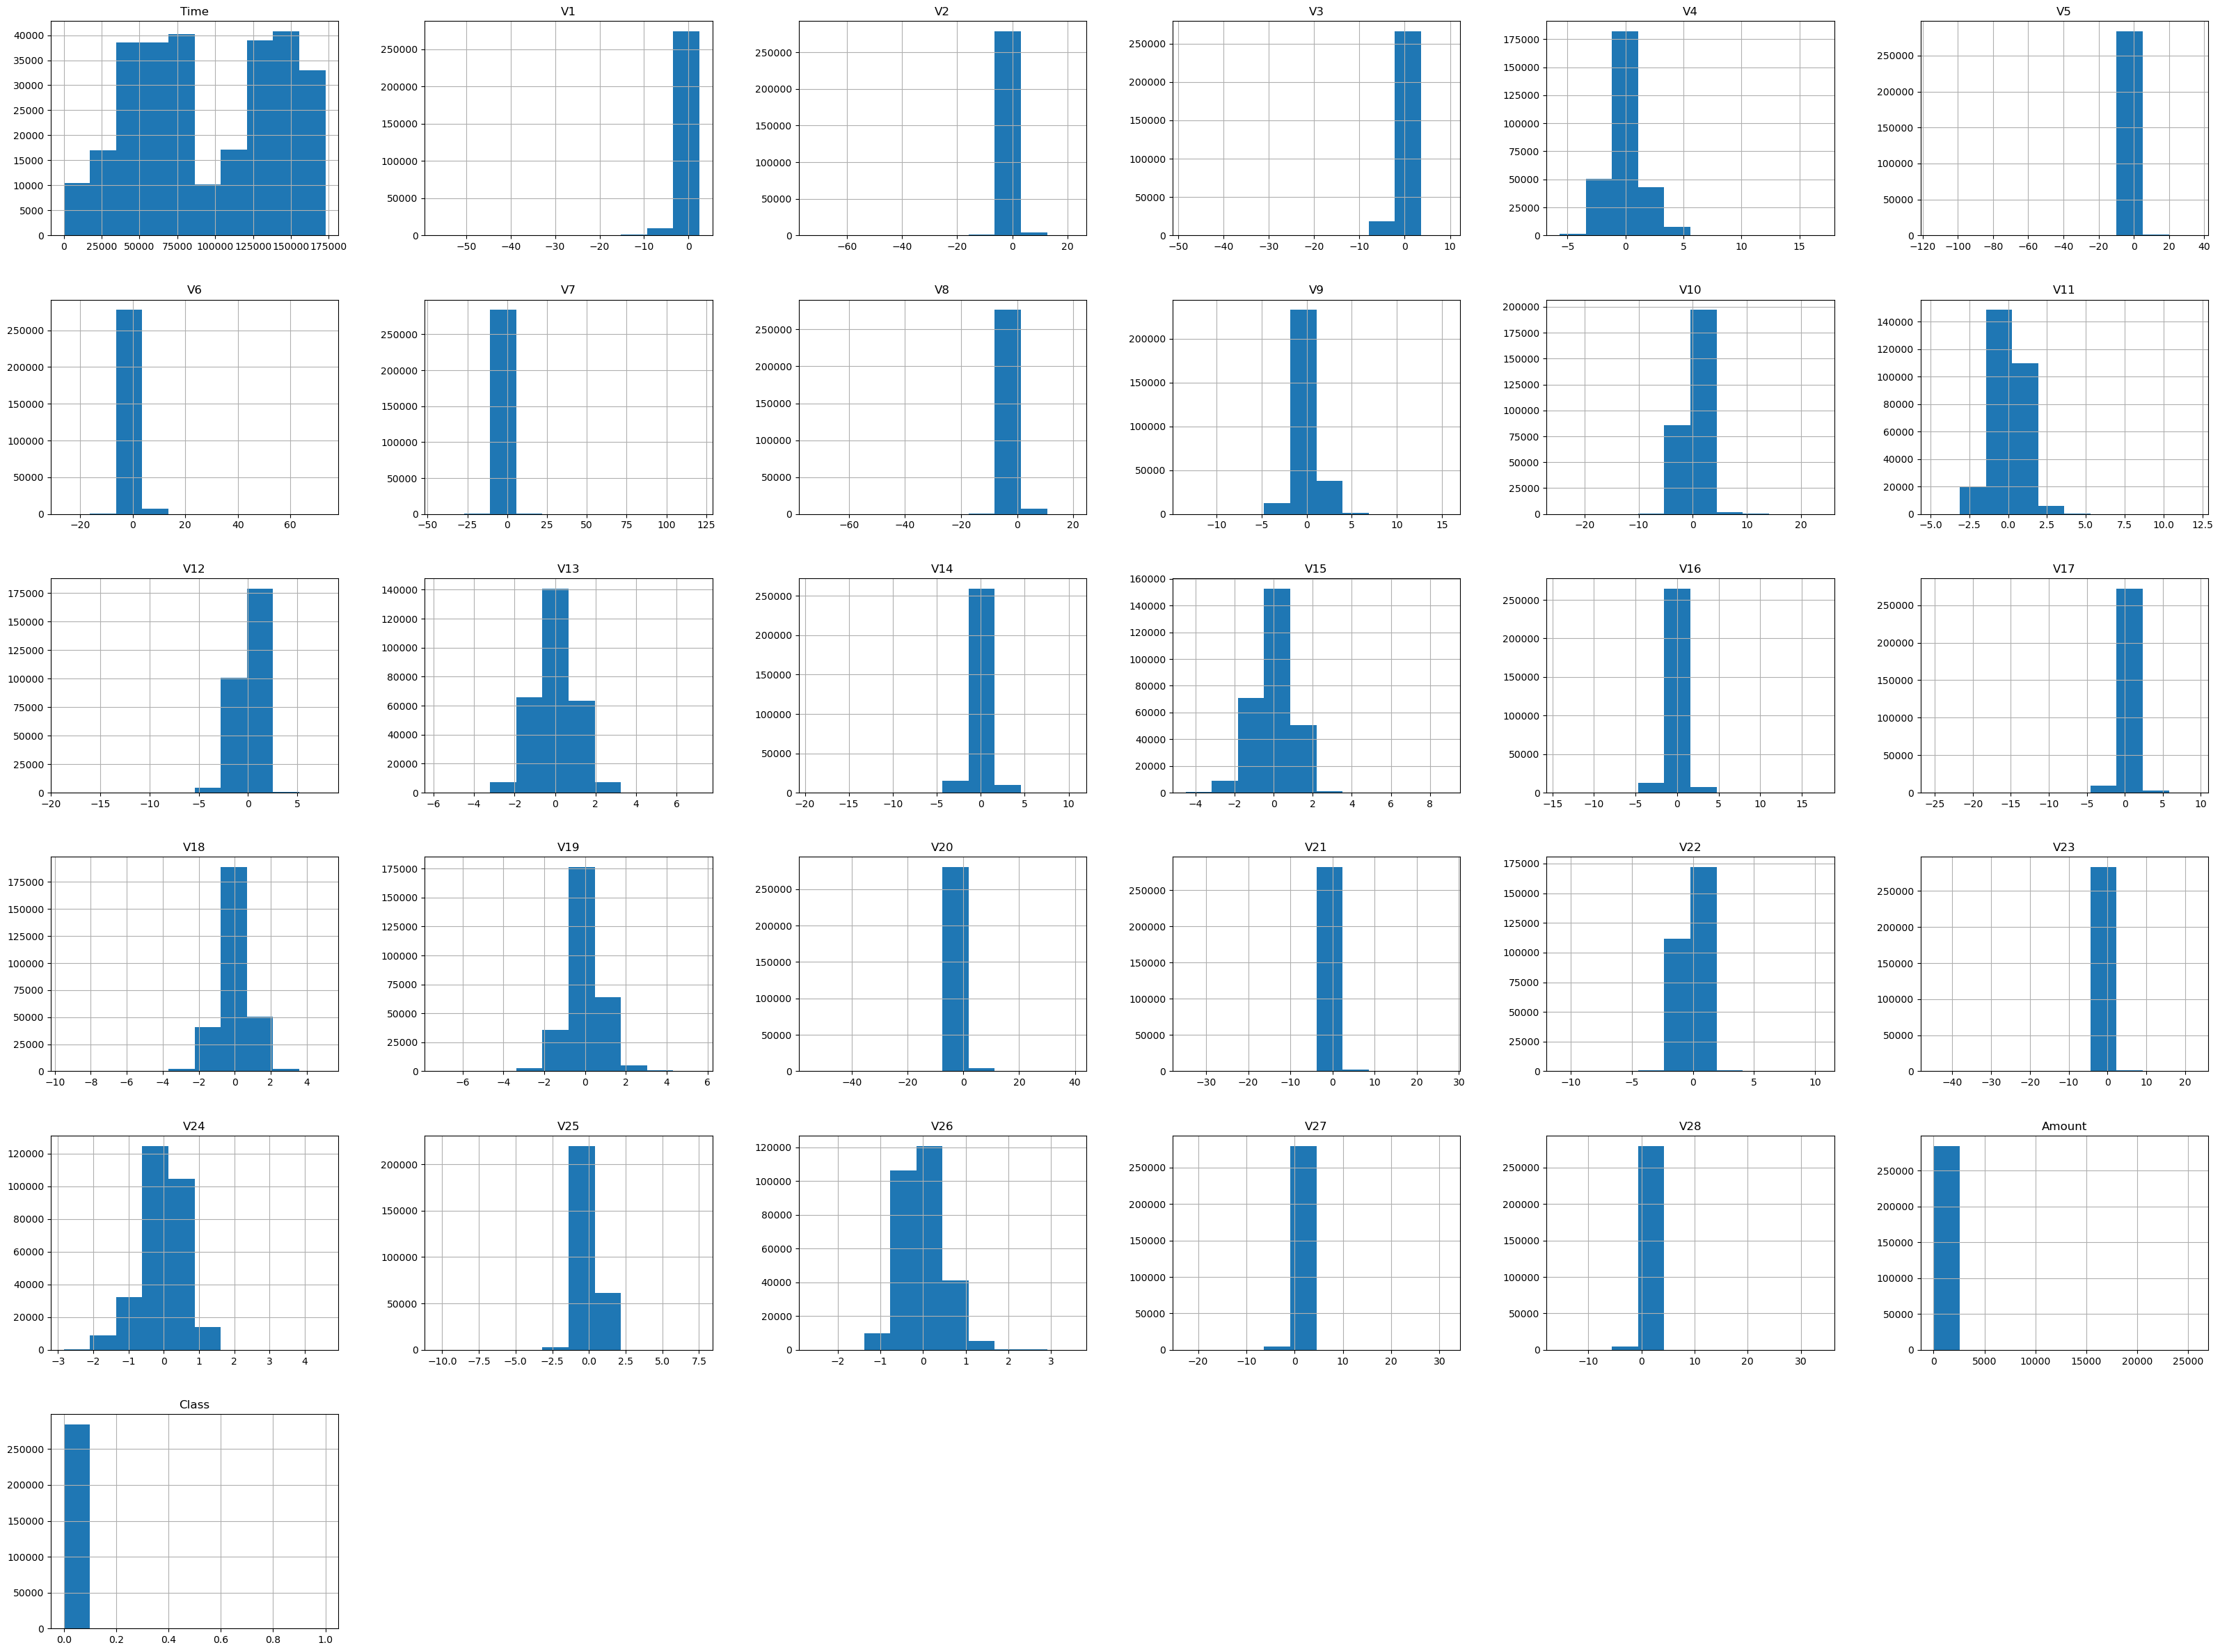

In [8]:
data.hist(figsize=(40,30))
plt.show()

<Axes: title={'center': 'Histogram of all transactions'}, ylabel='Frequency'>

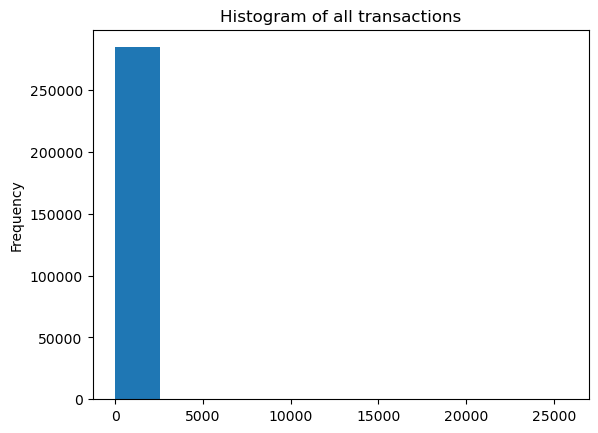

In [9]:
# Valid Transactions
data.Amount.plot.hist(title = 'Histogram of all transactions')

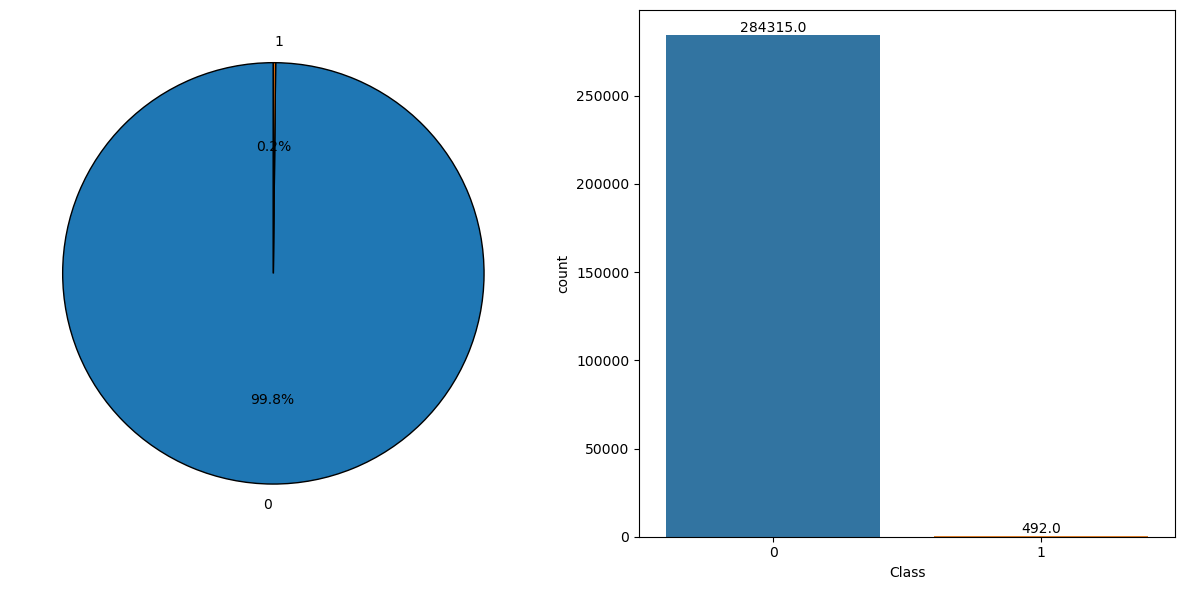

In [10]:

fraud = len(data[data['Class'] == 1]) / len(data) * 100
nofraud = len(data[data['Class'] == 0]) / len(data) * 100
fraud_percentage = [nofraud,fraud]

plt.figure(figsize=(12, 6))
# Pie chart
fraud_percentage = data['Class'].value_counts(normalize=True)
plt.subplot(1, 2, 1)
plt.pie(fraud_percentage, labels=fraud_percentage.index, autopct='%1.1f%%', startangle=90,
        wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})

# Countplot
plt.subplot(1, 2, 2)
ax = sns.countplot(x='Class', data=data)  # Use 'x=' to specify the column name explicitly
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, f'{rect.get_height()}', 
            ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [11]:
# Check class distribution
#data['Class'].value_counts()
vc = data['Class'].value_counts().to_frame().reset_index()
vc['percent'] = vc["count"].apply(lambda x : round(100*float(x) / len(data), 2))
vc = vc.rename(columns = {"index" : "Target", "count" : "Count"})
vc


,Class,Count,percent
0,0,284315,99.83
1,1,492,0.17


In [12]:
#sns.countplot(x="Class", data=data)

The dataset is highly imbalanced ! It's a big problem because classifiers will always predict the most common class without performing any analysis of the features and it will have a high accuracy rate, obviously not the correct one. To change that, I will proceed to random undersampling.

The simplest undersampling technique involves randomly selecting examples from the majority class and deleting them from the training dataset. This is referred to as random undersampling.

Although simple and effective, a limitation of this technique is that examples are removed without any concern for how useful or important they might be in determining the decision boundary between the classes. This means it is possible, or even likely, that useful information will be deleted.

## Balancing the Dataset：Under-sampling the Majority Class

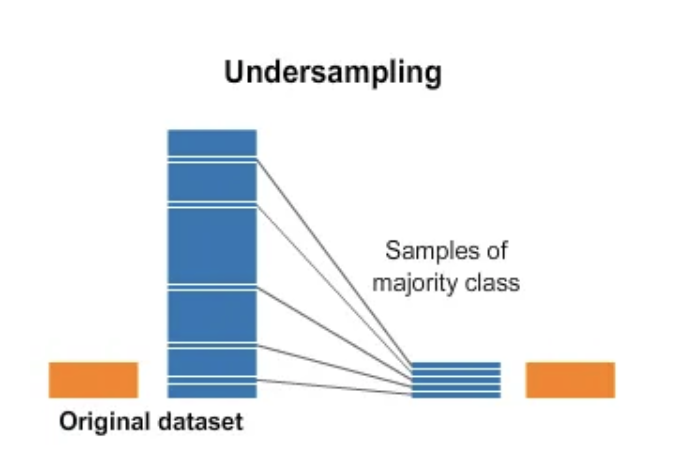

In [13]:
# Random Under-sampling

# Calculate number of instances in each class
count_class_0, count_class_1 = data['Class'].value_counts()

# Divide by class
df_class_0 = data[data['Class'] == 0]
df_class_1 = data[data['Class'] == 1]

# Random under-sampling
df_class_0_under = df_class_0.sample(count_class_1 * 4, random_state=42)  # Change multiplier to control class ratio

# Combine the data back
under_sample = pd.concat([df_class_0_under, df_class_1], axis=0)

# Shuffle the dataset to avoid any inherent ordering
under_sample = under_sample.sample(frac=1, random_state=42)

<Axes: xlabel='Class', ylabel='count'>

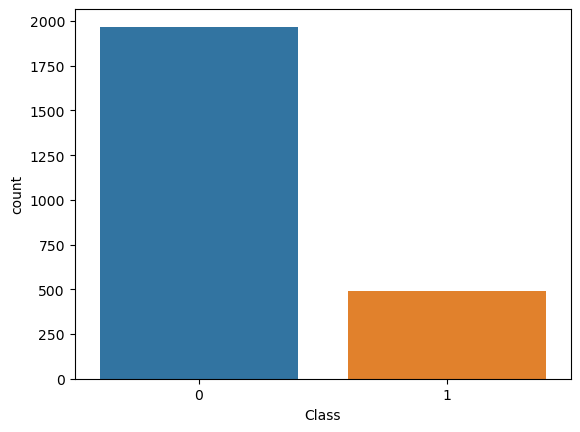

In [14]:
sns.countplot(x="Class", data=under_sample)

Text(0.5, 1.0, 'After')

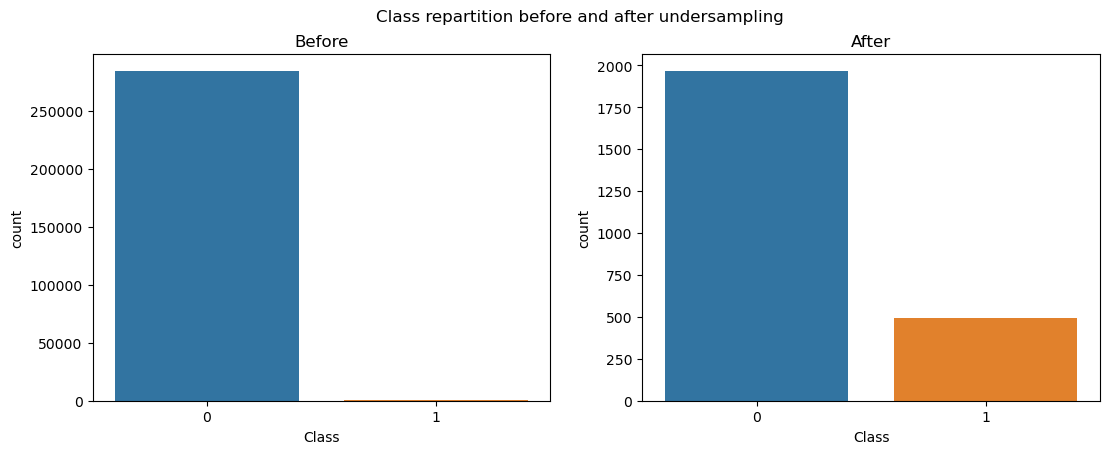

In [15]:
#visualizing undersampling results
fig, axs = plt.subplots(ncols=2, figsize=(13,4.5))
sns.countplot(x="Class", data=data, ax=axs[0])
sns.countplot(x="Class", data=under_sample, ax=axs[1])

fig.suptitle("Class repartition before and after undersampling")
a1=fig.axes[0]
a1.set_title("Before")
a2=fig.axes[1]
a2.set_title("After")

##  Data Preprocessing


### Remove outliers using IQR method

In [16]:
# Remove outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


# for col in ['Amount'] + [f'V{i}' for i in range(1, 29)]:
#     data = remove_outliers(data, col)

under_sample = remove_outliers(under_sample, 'Amount')

<Axes: title={'center': 'Histogram of all transactions'}, ylabel='Frequency'>

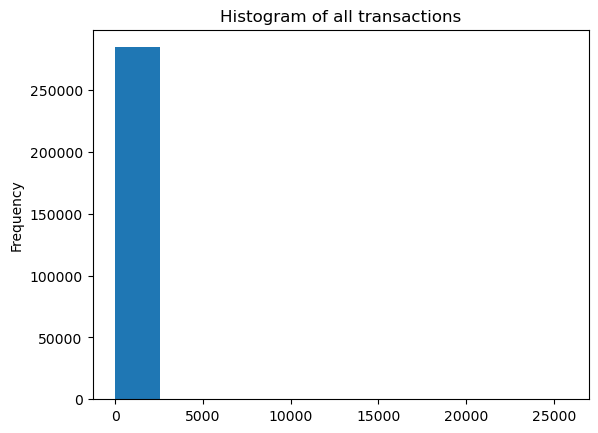

In [17]:
data.Amount.plot.hist(title = 'Histogram of all transactions')

### Split the Dataset

In [18]:
# Separate features and target
X = under_sample.drop('Class', axis=1)
y = under_sample['Class']


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
X_train.shape

(1760, 30)

In [20]:
y_train.shape

(1760,)

In [21]:
X_test.shape

(441, 30)

In [22]:
y_test.shape

(441,)

### Standardation

In [23]:

# Normalize 'Time' and 'Amount'
scaler = StandardScaler()
# under_sample[['Time', 'Amount']] = scaler.fit_transform(under_sample[['Time', 'Amount']])
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform( X_test)

### Convert to the format required for CNN

In [24]:
# Convert to the format required for CNN
X_train_cnn = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test_cnn = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

X_train_cnn.shape, X_test_cnn.shape

((1760, 30, 1), (441, 30, 1))


## Multilayer Neural Network with Tensorflow/Keras


### Assumptions and Limitations
* Assumptions:
PCA-transformed features sufficiently capture the dynamics necessary for detecting fraud.
The labels in the dataset are accurate and there are no misclassifications.

* Limitations:
PCA components are not interpretable, which means understanding which features most influence model decisions is difficult.
Models trained on past data may not perform well on new, unseen fraudulent tactics.


* Implement Dropout:
Dropout is a regularization technique where randomly selected neurons are ignored during training. This means they are “dropped-out” randomly. This technique forces the network to learn more robust features that are useful in conjunction with many different random subsets of the other neurons.

* Use Weight Regularization:
Apply L1 or L2 regularization, which adds a penalty on the size of the weights to the loss function. This discourages learning overly complex models.

* Batch Normalization:
This technique normalizes the input layer by adjusting and scaling activations. It can help to speed up training and has some regularization effects.

* Early Stopping：
Stop training as soon as the validation performance starts deteriorating, despite improvements in training performance.

In [25]:
#train the model
model = Sequential()
model.add(Dense(32, input_shape=(30,), activation='relu', kernel_regularizer=l2(0.02))),
model.add(BatchNormalization()),
model.add(Dropout(0.3)),
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.02))),
model.add(Dropout(0.3)),
model.add(Dense(8, activation='relu', kernel_regularizer=l2(0.02))),
model.add(Dropout(0.3)),
model.add(Dense(4, activation='relu', kernel_regularizer=l2(0.02))),
model.add(Dropout(0.3)),
model.add(Dense(1, activation='sigmoid'))

/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


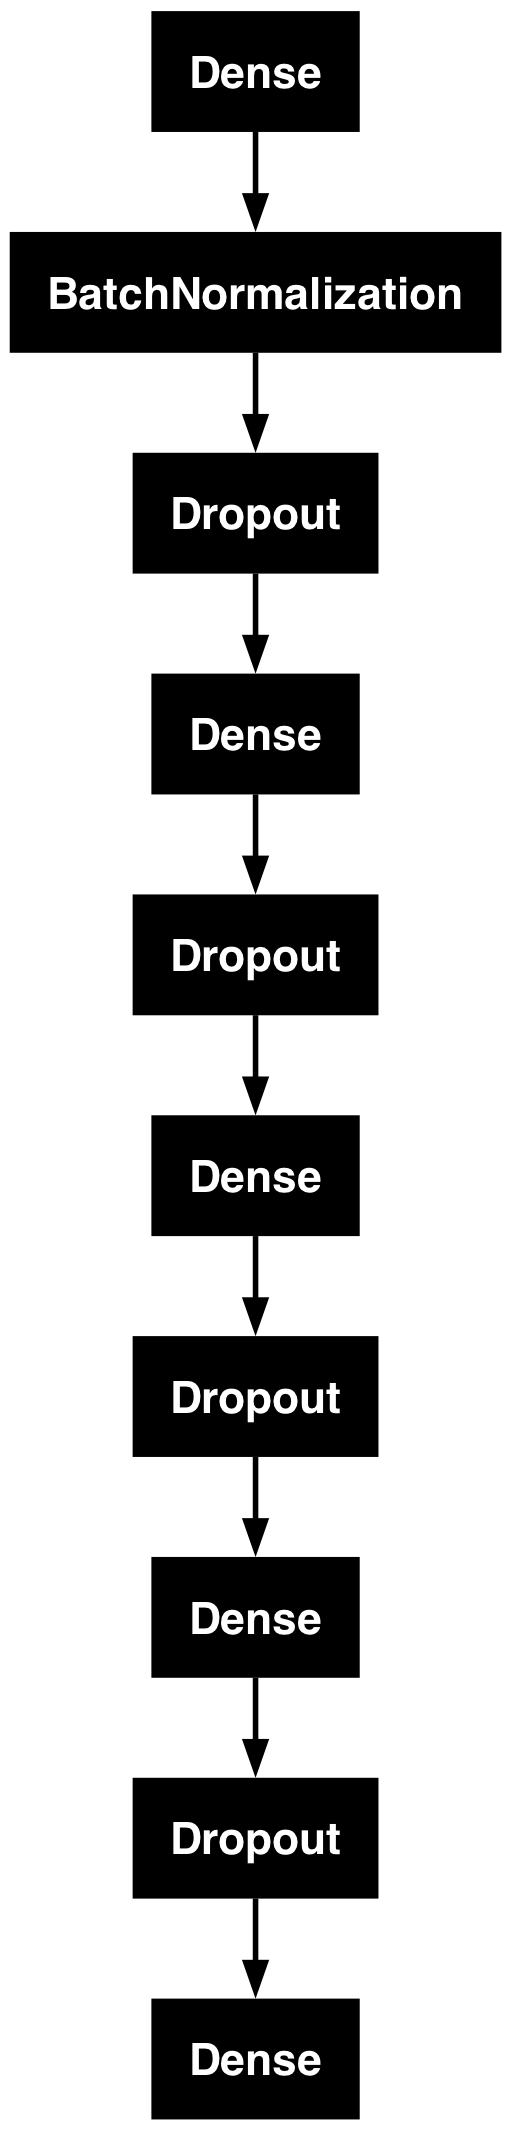

In [26]:

plot_model(model)

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,825 (7.13 KB)

 Trainable params: 1,761 (6.88 KB)

 Non-trainable params: 64 (256.00 B)

In [28]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001) #optimizer
# Compile the model
model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy']) #metrics

###  Implementing Random Search and Early Stopping

In [29]:
from kerastuner.tuners import RandomSearch

# Define the model building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                    activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                    activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

# Initialize RandomSearch
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Set a low number for demonstration; increase it for real use
    executions_per_trial=3,
    directory='output',
    project_name='CreditCardFraud'
)

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss',  min_delta=0, patience=5, verbose=1, restore_best_weights=True)

# Execute the search
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stop])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]


/var/folders/b0/lkbpnp6s6hn0fl17ksx6gwhw0000gn/T/ipykernel_66707/1767371258.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Reloading Tuner from output/CreditCardFraud/tuner0.json


/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [30]:
#earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=15, verbose=1,mode='auto', baseline=None, restore_best_weights=False)


In [31]:
# Fit the best model
history = best_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stop],validation_split = 0.15, verbose=1)
history_dict = history.history


Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8616 - loss: 0.5053 - val_accuracy: 0.9161 - val_loss: 0.1900
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.9424 - loss: 0.1651 - val_accuracy: 0.9592 - val_loss: 0.1027
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.9705 - loss: 0.1003 - val_accuracy: 0.9705 - val_loss: 0.0832
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.9743 - loss: 0.0828 - val_accuracy: 0.9819 - val_loss: 0.0730
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.9766 - loss: 0.0838 - val_accuracy: 0.9819 - val_loss: 0.0682
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - accuracy: 0.9811 - loss: 0.0597 - val_accuracy: 0.9819 - val_loss: 0.0668
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - accuracy: 0.9793 - loss: 0.0748 - val_accuracy: 0.9796 - val_loss: 0.0668
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - accuracy: 0.9826 - loss: 0.0613 - val_accuracy: 0.98

In [32]:
# history = model.fit(X_train.values, y_train.values, epochs = 6, batch_size=5, validation_split = 0.15, verbose = 0,
#                     callbacks = [earlystopper])
#history_dict = history.history


##  Model Evaluation for NN


In [33]:
# Evaluate the model
loss, accuracy = best_model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.9811 - loss: 0.0764
Loss: 0.06593962758779526
Accuracy: 0.9818593859672546


In [34]:

# Predict probabilities
y_pred_proba = best_model.predict(X_test)

# Predict classes
y_pred = (y_pred_proba > 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Precision, Recall, F1-Score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1_score}')


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy: 0.981859410430839
Precision: 0.9868421052631579
Recall: 0.9146341463414634
F1-Score: 0.9493670886075949


### Overfitting/Underfitting:

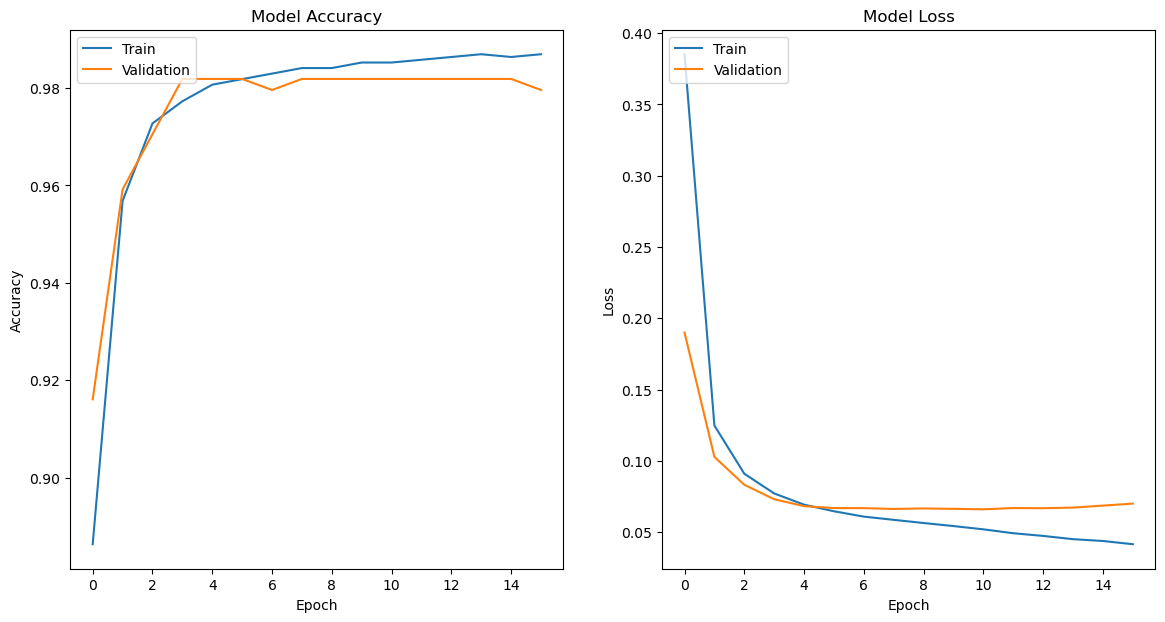

In [35]:
# Plot accuracy and loss
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


Accuracy Graph Analysis:

* Training Accuracy increases consistently, which is indicative of the model learning from the training data.
* Validation Accuracy also increases and closely follows the training accuracy. This is generally a good sign as it suggests that the model is generalizing well on unseen data.
* Gap Between Training and Validation Accuracy: The small gap between the training and validation accuracy is favorable as it implies that there is no significant overfitting. Both curves are ascending, which suggests that the model could potentially improve with more training epochs.

Loss Graph Analysis:

* Training Loss decreases steadily, showing that the model is increasingly fitting the training data better.
* Validation Loss decreases initially and then starts to increase slightly towards the latest epochs. This upward trend in validation loss while the training loss continues to decrease could be an early sign of overfitting. The model may be starting to learn specifics about the training data that do not generalize to the validation data.

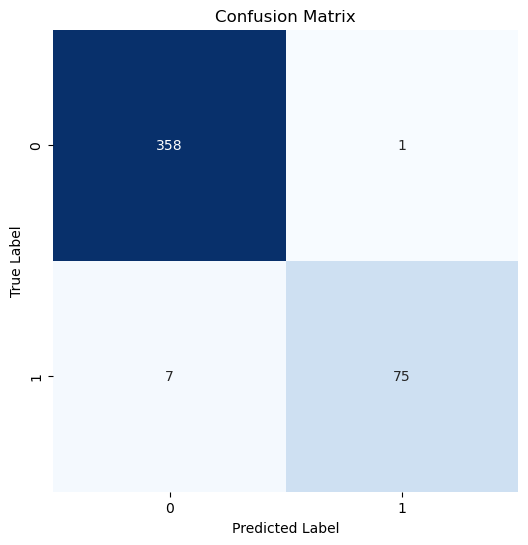

In [36]:


# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



The confusion matrix indicates that the model has performed well in classifying the classes. It shows a good balance of precision and recall, with few false positives and false negatives. However, the false negatives (Type II errors) could be critical depending on the application since they represent missed fraud detections.

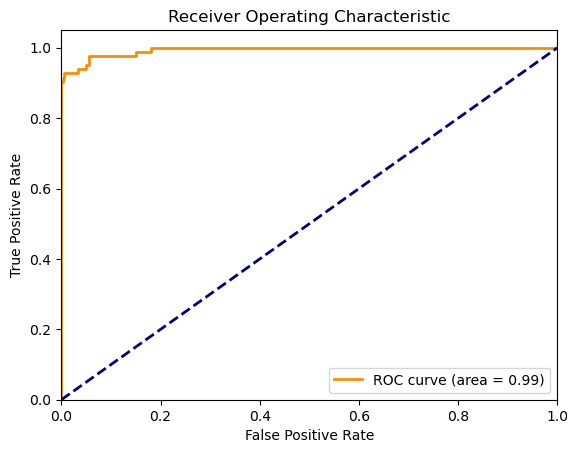

In [37]:
# ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



The ROC curve shows an excellent performance with an AUC of 1.00. This suggests perfect discrimination between positive and negative classes. However, such a perfect score may sometimes be suspect in practical scenarios, as it could imply overfitting especially if the test data is not representative or similarly 'easy' as the training set.

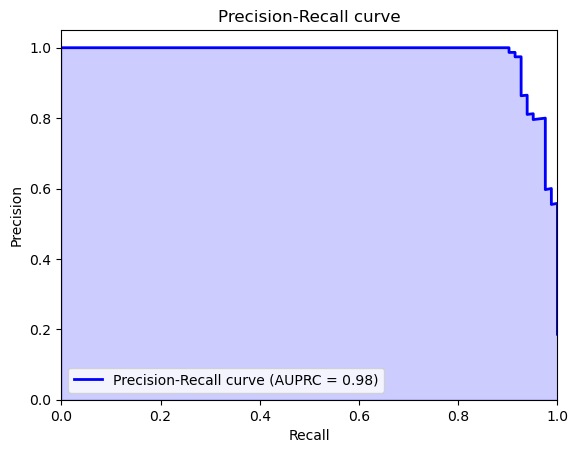

In [38]:
# Precision-Recall curve and AUPRC
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
auprc = average_precision_score(y_test, y_pred_proba)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AUPRC = %0.2f)' % auprc)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()

The Precision-Recall curve also shows excellent performance, nearly reaching the top right corner, with an AUPRC close to 1 (0.99). This indicates both high recall and high precision, demonstrating the model’s ability to handle the imbalanced data effectively.

In [39]:
# # Save the model
# best_model.save('autoencoder_fraud_detection.h5')

# # Load the model (in a different file or system)
# from tensorflow.keras.models import load_model
# loaded_model = load_model('autoencoder_fraud_detection.h5')


## Building and Training the CNN

In [40]:
from bayes_opt import BayesianOptimization

# Define a function to create the CNN model
def create_model(learning_rate, dropout_rate, l2_reg):
    model = Sequential([
        Conv1D(filters=32, kernel_size=2, activation='relu', kernel_regularizer=l2(l2_reg), input_shape=(X_train_cnn.shape[1], 1)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(dropout_rate),
        Conv1D(filters=64, kernel_size=2, activation='relu', kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(dropout_rate),
        Flatten(),
        Dense(100, activation='relu', kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define a function to optimize
def optimize_model(learning_rate, dropout_rate, l2_reg):
    model = create_model(learning_rate, dropout_rate, l2_reg)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train_cnn, y_train, epochs=80, batch_size=32, validation_data=(X_test_cnn, y_test), callbacks=[early_stopping], verbose=0)
    _, accuracy = model.evaluate(X_test_cnn, y_test, verbose=0)
    return accuracy

# Define the parameter space
param_bounds = {
    'learning_rate': (0.0001, 0.01),
    'dropout_rate': (0.3, 0.5),
    'l2_reg': (0.0001, 0.01)
}

# Perform Bayesian Optimization
optimizer = BayesianOptimization(f=optimize_model, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=10, n_iter=30)


|   iter    |  target   | dropou... |  l2_reg   | learni... |
-------------------------------------------------------------


/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 1         | 0.9683    | 0.3749    | 0.009512  | 0.007347  |
| 2         | 0.9728    | 0.4197    | 0.001645  | 0.001644  |
| 3         | 0.966     | 0.3116    | 0.008675  | 0.006051  |
| 4         | 0.9773    | 0.4416    | 0.0003038 | 0.009702  |
| 5         | 0.9773    | 0.4665    | 0.002202  | 0.0019    |
| 6         | 0.9637    | 0.3367    | 0.003112  | 0.005295  |
| 7         | 0.966     | 0.3864    | 0.002983  | 0.006157  |
| 8         | 0.9615    | 0.3279    | 0.002992  | 0.003727  |
| 9         | 0.9637    | 0.3912    | 0.007873  | 0.002077  |
| 10        | 0.9773    | 0.4028    | 0.005965  | 0.0005599 |


/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 11        | 0.9569    | 0.4943    | 0.006361  | 0.00986   |


/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 12        | 0.9683    | 0.454     | 0.001266  | 0.004897  |


/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 13        | 0.9705    | 0.4101    | 0.007611  | 0.0001    |


/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 14        | 0.9751    | 0.4032    | 0.005593  | 0.0008835 |


/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 15        | 0.9796    | 0.4019    | 0.00817   | 0.0002988 |


/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 16        | 0.9705    | 0.3992    | 0.006081  | 0.0001    |


/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 17        | 0.966     | 0.4038    | 0.009933  | 0.002091  |


/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 18        | 0.9728    | 0.4691    | 0.002711  | 0.002383  |


/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 19        | 0.9751    | 0.4653    | 0.004636  | 0.001392  |


/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 20        | 0.9683    | 0.4646    | 0.002217  | 0.004194  |


/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 21        | 0.9751    | 0.3617    | 0.008625  | 0.001029  |


/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 22        | 0.966     | 0.4671    | 0.003044  | 0.0001    |


/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 23        | 0.9637    | 0.4016    | 0.007093  | 0.001267  |


/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 24        | 0.9773    | 0.402     | 0.008127  | 0.0004033 |


/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 25        | 0.9728    | 0.4666    | 0.002555  | 0.002431  |


/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 26        | 0.9728    | 0.442     | 0.0004797 | 0.009257  |


/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 27        | 0.9728    | 0.4028    | 0.005424  | 0.0001    |


/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 28        | 0.9773    | 0.4013    | 0.008582  | 0.0004104 |


/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 29        | 0.9728    | 0.4014    | 0.007909  | 0.0001    |


/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 30        | 0.9796    | 0.402     | 0.008683  | 0.0007105 |


/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 31        | 0.9773    | 0.4019    | 0.008519  | 0.0003543 |


/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 32        | 0.9773    | 0.4019    | 0.009226  | 0.0004966 |


/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 33        | 0.9773    | 0.401     | 0.008488  | 0.001465  |


/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 34        | 0.9773    | 0.4015    | 0.00959   | 0.0007352 |


/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 35        | 0.9728    | 0.402     | 0.008549  | 0.0002913 |


/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 36        | 0.9683    | 0.4013    | 0.008259  | 0.001106  |


/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 37        | 0.9728    | 0.3457    | 0.00246   | 0.001657  |


/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 38        | 0.9683    | 0.4022    | 0.00899   | 0.0009551 |


/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 39        | 0.9773    | 0.4011    | 0.008841  | 0.00126   |


/Users/boyazeng/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 40        | 0.9773    | 0.3116    | 0.004596  | 0.0018    |


In [41]:
# Get the best parameters
best_params = optimizer.max['params']
best_learning_rate = best_params['learning_rate']
best_dropout_rate = best_params['dropout_rate']
best_l2_reg = best_params['l2_reg']

# Train the final model with the best parameters
final_model = create_model(best_learning_rate, best_dropout_rate, best_l2_reg)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the best model
history =final_model.fit(X_train_cnn, y_train, epochs=50, batch_size=32, validation_data=(X_test_cnn, y_test), callbacks=[early_stopping])

history_dict = history.history


Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7016 - loss: 2.2634 - val_accuracy: 0.8866 - val_loss: 1.9146
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8610 - loss: 1.9008 - val_accuracy: 0.8798 - val_loss: 1.7707
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9018 - loss: 1.7481 - val_accuracy: 0.8912 - val_loss: 1.6591
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9124 - loss: 1.6077 - val_accuracy: 0.8980 - val_loss: 1.5571
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9326 - loss: 1.4981 - val_accuracy: 0.9138 - val_loss: 1.4557
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9433 - loss: 1.3866 - val_accuracy: 0.9297 - val_loss: 1.3537
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9382 - loss: 1.3176 - val_accuracy: 0.9524 - val_loss: 1.2670
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9357 - loss: 1.2638 - val_accuracy: 0.9524 - val_loss:

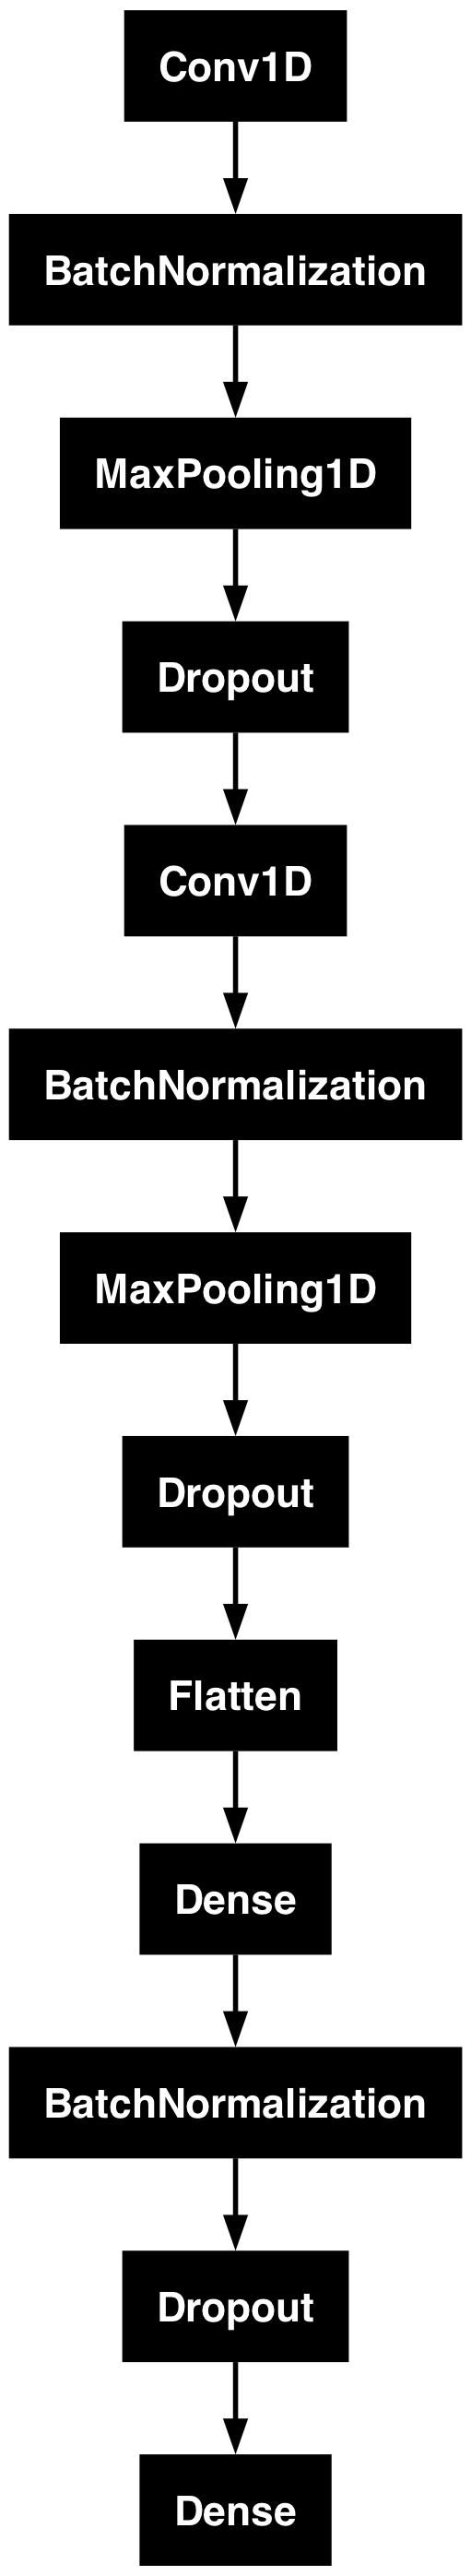

In [42]:

plot_model(final_model)

In [43]:
final_model.summary()

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_80 (Conv1D)              │ (None, 29, 32)         │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_120         │ (None, 29, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_80 (MaxPooling1D) │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_120 (Dropout)           │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_81 (Conv1D)              │ (None, 13, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_121         │ (None, 13, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_81 (MaxPooling1D) │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_121 (Dropout)           │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_40 (Flatten)            │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 100)            │        38,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_122         │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_122 (Dropout)           │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,141 (508.37 KB)

 Trainable params: 43,249 (168.94 KB)

 Non-trainable params: 392 (1.53 KB)

 Optimizer params: 86,500 (337.89 KB)

## Model Evaluation for CNN

In [44]:

# Evaluate the final model
loss, accuracy = final_model.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - accuracy: 0.9742 - loss: 0.2642
Test Loss: 0.266893208026886
Test Accuracy: 0.9750567078590393


In [45]:

# Predict probabilities
y_pred_prob = final_model.predict(X_test_cnn).ravel()
# Predict classes
y_pred = (y_pred_prob > 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Precision, Recall, F1-Score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1_score}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy: 0.9750566893424036
Precision: 1.0
Recall: 0.8658536585365854
F1-Score: 0.9281045751633987


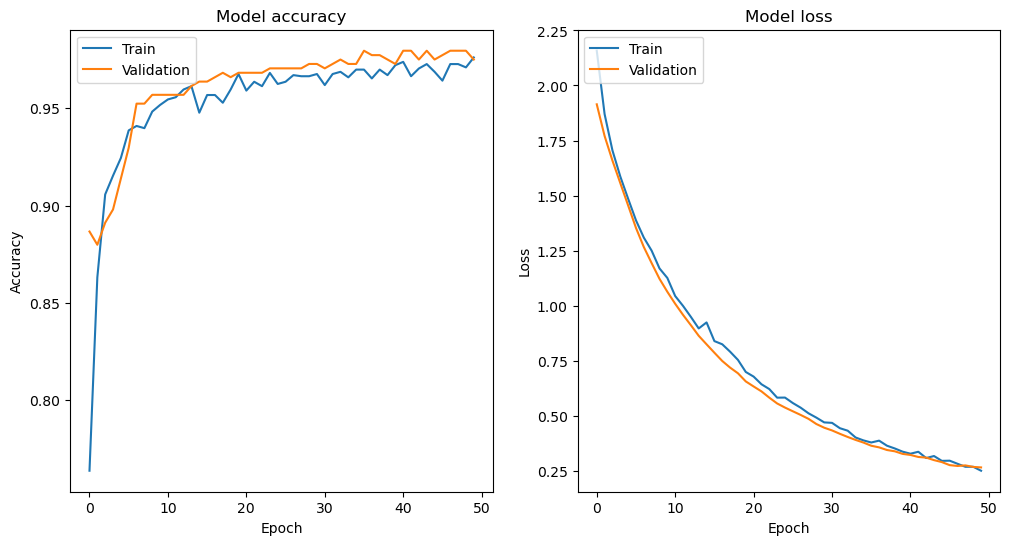

In [46]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

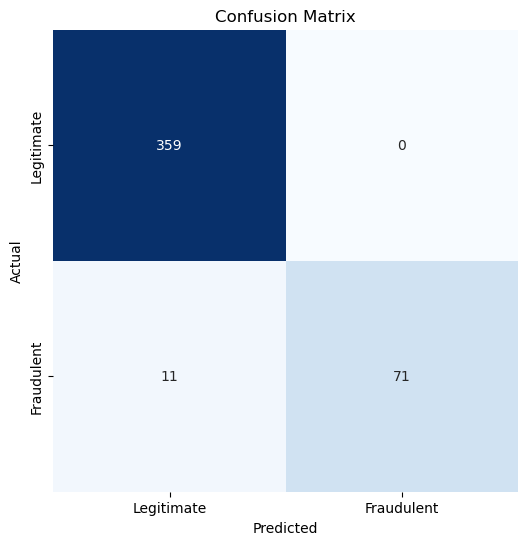

In [47]:


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Legitimate', 'Fraudulent'], yticklabels=['Legitimate', 'Fraudulent'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

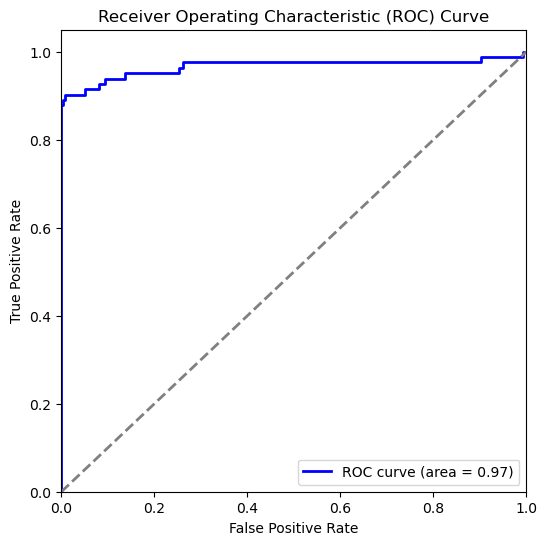

In [48]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



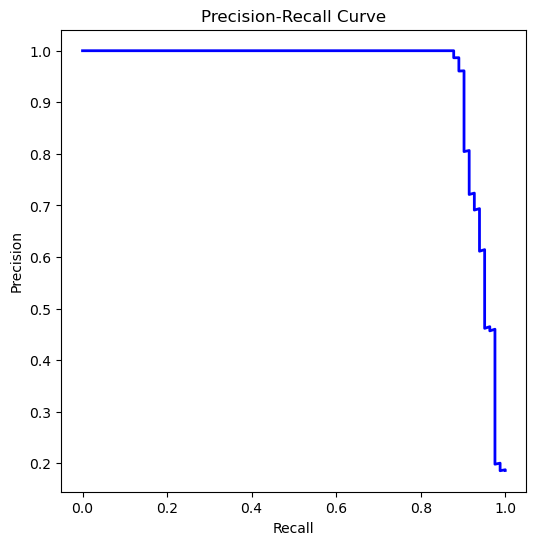

In [49]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()